The objective of this notebook is to learn about sequential neural networks used in Text Analysis. Following steps have been performed on the disaster tweets datasets.
<UL> 
  <li>Data Cleaning : 
    <ul><li>Removal of emojis, @, word abbreviations etc.</li></ul> 
  </li>
  <li>Data Preprocessing :
    <ul>
      <li> Tokenization</li>
      <li> Create encoded documents</li>
      <li> Padding the documents</li>
      <li> Creating GloVe word embeddings</li>
    </ul>
  </li>
  <li>LSTM</li>
  <li>Bidirectional LSTM</li>
  <li>GRU</li>
  <li>Attention Model</li>
</UL>

## Data Cleaning and Pre-processing

### Imports

In [2]:
import numpy as np
import pandas as pd

import keras
import nltk
import re
import string

from keras.preprocessing.text import one_hot
from keras.layers import LSTM, Embedding, Dense, Bidirectional, GlobalMaxPool2D, BatchNormalization, Dropout, TimeDistributed, GlobalMaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import SpatialDropout1D, GRU
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Reading Data

In [3]:
#importing data from local filesystem
from google.colab import files
uploaded = files.upload()

import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Saving train.csv to train.csv
Saving test.csv to test.csv


In [4]:
test.shape, train.shape

((3263, 4), (7613, 5))

In [5]:
label= train['target']

In [6]:
train.drop(['target'],axis=1,inplace=True)

### Concat train and test records

In [7]:
data= pd.concat([train,test])
data.shape,train.shape,test.shape

((10876, 4), (7613, 4), (3263, 4))

### Data Cleaning 

In [8]:
def clean_text(record):
  record = record.lower()
  record = re.sub('\[.*?\]', '', record)
  record = re.sub('https?://\S+|www\.\S+', '', record)
  record = re.sub('<.*?>+', '', record)
  record = re.sub('[%s]' % re.escape(string.punctuation), '', record)
  record = re.sub('\n', '', record)
  record = re.sub('\w*\d\w*', '', record)
  return record

data['text'] = data['text'].apply(lambda x: clean_text(x))

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
    
data['text']=data['text'].apply(lambda x: remove_emoji(x))


In [10]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

print(expand_contractions("can't shouldn't won't haven't"))
data['text'] =data['text'].apply(expand_contractions)


cannot should not will not have not


In [11]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [12]:
train.shape, test.shape

((7613, 4), (3263, 4))

In [13]:
tweets= train['text'].copy()
tweets_test = test['text'].copy()

### Tokenization and Preparing padded dataset

In [14]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(tweets)
vocab_size_train = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(tweets)
# pad documents to a max length of 4 word
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [15]:
tweets = padded_docs

In [16]:
tweets[0]

array([ 107, 4290,   20,    1,  834,    5,   18,  231,  123, 1629, 4291,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [17]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(tweets_test)
vocab_size_test = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(tweets_test)
# pad documents to a max length of 4 words
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [18]:
tweets_test= padded_docs

### Word Embedding - GloVe

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [20]:
!unzip -uq "/content/gdrive/My Drive/Colab Notebooks/DisasterTweets/glove.6B.200d.txt" -d "/content/gdrive/My Drive/Colab Notebooks/DisasterTweets/glove.6B.200d.txt"


In [21]:
embeddings_index = dict()
f = open("/content/gdrive/My Drive/Colab Notebooks/DisasterTweets/glove.6B.200d.txt/glove.6B.200d.txt")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()
print("Loaded %s word vectors " %len(embeddings_index) )

Loaded 400000 word vectors 


In [22]:
embedding_matrix = np.zeros((vocab_size_train, 200))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    embedding_matrix[i] = embedding_vector 

In [23]:
embedding_matrix.shape

(16834, 200)

In [24]:
vocab_size_train

16834

### Embedding layer and Optimizer

In [25]:
e = Embedding(vocab_size_train, 200, weights = [embedding_matrix], input_length = 100, trainable = False)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tweets, label)

In [27]:
opt =  Adam(lr = 0.001, decay = 1e-6)

## LSTM

In [28]:
model = Sequential()
model.add(e)
model.add(LSTM(100, dropout = 0.3, recurrent_dropout= 0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 64, verbose = 1 )

Epoch 1/20
90/90 [==============================] - 18s 158ms/step - loss: 0.6790 - accuracy: 0.5518 - val_loss: 0.6832 - val_accuracy: 0.5588
Epoch 2/20
90/90 [==============================] - 14s 152ms/step - loss: 0.6345 - accuracy: 0.6488 - val_loss: 0.6594 - val_accuracy: 0.5751
Epoch 3/20
90/90 [==============================] - 14s 155ms/step - loss: 0.5999 - accuracy: 0.6813 - val_loss: 0.6339 - val_accuracy: 0.6439
Epoch 4/20
90/90 [==============================] - 14s 153ms/step - loss: 0.5687 - accuracy: 0.7182 - val_loss: 0.6187 - val_accuracy: 0.6896
Epoch 5/20
90/90 [==============================] - 14s 154ms/step - loss: 0.5293 - accuracy: 0.7395 - val_loss: 0.5629 - val_accuracy: 0.7122
Epoch 6/20
90/90 [==============================] - 14s 154ms/step - loss: 0.4944 - accuracy: 0.7735 - val_loss: 0.5736 - val_accuracy: 0.6922
Epoch 7/20
90/90 [==============================] - 14s 153ms/step - loss: 0.4744 - accuracy: 0.7867 - val_loss: 0.5493 - val_accuracy: 0.7579

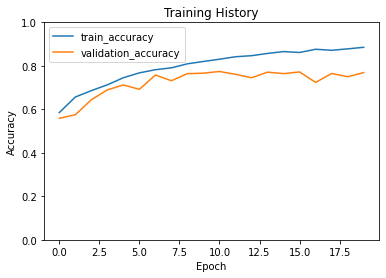

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1]);

In [31]:
y_pred_lstm =  model.predict_classes(X_val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
from sklearn.metrics import accuracy_score
accuracy_lstm = accuracy_score(y_pred_lstm, y_val)
print("Accuracy with LSTM model: {} %".format(accuracy_lstm * 100))

Accuracy with LSTM model: 76.89075630252101 %


## Bidirectional LSTM

In [33]:
model = Sequential()
model.add(e)
model.add(Bidirectional(LSTM(100, dropout = 0.3, recurrent_dropout = 0.3)))
model.add(BatchNormalization())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [34]:
hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 64, verbose = 1)

Epoch 1/20
90/90 [==============================] - 31s 303ms/step - loss: 0.6912 - accuracy: 0.5795 - val_loss: 0.6594 - val_accuracy: 0.5725
Epoch 2/20
90/90 [==============================] - 26s 290ms/step - loss: 0.6002 - accuracy: 0.6764 - val_loss: 0.6348 - val_accuracy: 0.6350
Epoch 3/20
90/90 [==============================] - 26s 290ms/step - loss: 0.5442 - accuracy: 0.7241 - val_loss: 0.6228 - val_accuracy: 0.6465
Epoch 4/20
90/90 [==============================] - 26s 292ms/step - loss: 0.5188 - accuracy: 0.7485 - val_loss: 0.5779 - val_accuracy: 0.7064
Epoch 5/20
90/90 [==============================] - 27s 302ms/step - loss: 0.4893 - accuracy: 0.7653 - val_loss: 0.5753 - val_accuracy: 0.7132
Epoch 6/20
90/90 [==============================] - 26s 292ms/step - loss: 0.4534 - accuracy: 0.7935 - val_loss: 0.6422 - val_accuracy: 0.7064
Epoch 7/20
90/90 [==============================] - 27s 298ms/step - loss: 0.4247 - accuracy: 0.8102 - val_loss: 0.5526 - val_accuracy: 0.7384

In [35]:
y_pred_bilstm = model.predict_classes(X_val)
accuracy_bilstm = accuracy_score(y_pred_bilstm, y_val)
print("Accuracy of Bidirectiona LSTM: {} %".format(accuracy_bilstm * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy of Bidirectiona LSTM: 74.21218487394958 %


(0.0, 1.0)

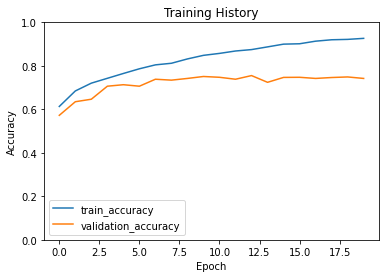

In [36]:
plt.plot(hist.history['accuracy'], label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])


## GRUs

In [37]:
model = Sequential()
model.add(e)
model.add(SpatialDropout1D(0.3))
model.add(GRU(100))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [38]:
hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 64, verbose = 1)

Epoch 1/20
90/90 [==============================] - 7s 11ms/step - loss: 0.6851 - accuracy: 0.5721 - val_loss: 0.6862 - val_accuracy: 0.5588
Epoch 2/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6842 - accuracy: 0.5677 - val_loss: 0.6887 - val_accuracy: 0.5588
Epoch 3/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6816 - accuracy: 0.5774 - val_loss: 0.6866 - val_accuracy: 0.5588
Epoch 4/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6803 - accuracy: 0.5810 - val_loss: 0.6865 - val_accuracy: 0.5588
Epoch 5/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6832 - accuracy: 0.5714 - val_loss: 0.6865 - val_accuracy: 0.5588
Epoch 6/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6839 - accuracy: 0.5687 - val_loss: 0.6867 - val_accuracy: 0.5588
Epoch 7/20
90/90 [==============================] - 1s 6ms/step - loss: 0.6834 - accuracy: 0.5706 - val_loss: 0.6870 - val_accuracy: 0.5588
Epoch 8/20
90/90 [=

In [39]:
y_pred_gru = model.predict_classes(X_val)
accuracy_gru = accuracy_score(y_pred_gru, y_val)
print('Accuracy of GRU model: {} %'.format(accuracy_gru * 100 ))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy of GRU model: 63.60294117647059 %


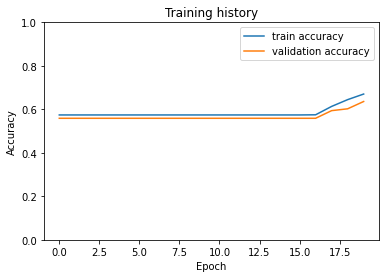

In [40]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Attention Model

In [41]:
from keras.layers import Layer
import keras.backend as K

In [42]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [43]:
inputs=keras.Input(shape=(max_length,))
x=(e)(inputs)
att_in=LSTM(100,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)
outputs=Dense(1,activation='sigmoid',trainable=True)(att_out)
modelA=Model(inputs,outputs)
modelA.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  3366800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           120400    
_________________________________________________________________
attention (attention)        (None, 100)               150       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,487,451
Trainable params: 120,651
Non-trainable params: 3,366,800
_________________________________________________________________


In [44]:
modelA.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
history = modelA.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 64, verbose = 1)

Epoch 1/20
90/90 [==============================] - 16s 156ms/step - loss: 0.6728 - accuracy: 0.5802 - val_loss: 0.6431 - val_accuracy: 0.6239
Epoch 2/20
90/90 [==============================] - 14s 160ms/step - loss: 0.6178 - accuracy: 0.6545 - val_loss: 0.5948 - val_accuracy: 0.6901
Epoch 3/20
90/90 [==============================] - 14s 157ms/step - loss: 0.5907 - accuracy: 0.6838 - val_loss: 0.5853 - val_accuracy: 0.6954
Epoch 4/20
90/90 [==============================] - 15s 163ms/step - loss: 0.5677 - accuracy: 0.7178 - val_loss: 0.5804 - val_accuracy: 0.6964
Epoch 5/20
90/90 [==============================] - 14s 159ms/step - loss: 0.5055 - accuracy: 0.7594 - val_loss: 0.5658 - val_accuracy: 0.7111
Epoch 6/20
90/90 [==============================] - 14s 158ms/step - loss: 0.5007 - accuracy: 0.7629 - val_loss: 0.5471 - val_accuracy: 0.7285
Epoch 7/20
90/90 [==============================] - 14s 159ms/step - loss: 0.4709 - accuracy: 0.7840 - val_loss: 0.5363 - val_accuracy: 0.7484

In [46]:
y_pred_attention = modelA.predict(X_val)
for i in range(len(y_pred_attention)):
  if(y_pred_attention[i] > 0.5) : 
    y_pred_attention[i] = 1
  else:
    y_pred_attention[i] = 0

from sklearn.metrics import accuracy_score
accuracy_attention = accuracy_score(y_pred_attention, y_val)
print("The accuracy for the attention model is {} %".format(accuracy_attention*100))

The accuracy for the attention model is 74.68487394957984 %


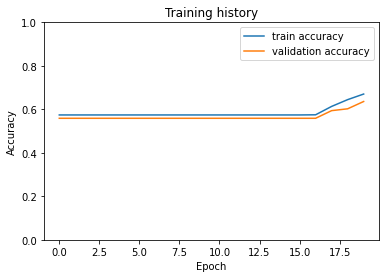

In [47]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);